In [1]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos
from climpyrical.mask import gen_raster_mask_from_vector
import climpyrical.spytialProcess as sp
from climpyrical.rkrig import krigit_north

from pkg_resources import resource_filename


from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")
font = {'weight' : 'bold',
        'size'   : 15}
%load_ext autoreload
%autoreload 2

In [2]:
OLD_PATH = resource_filename(
    'climpyrical',
    'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

# dsold = xr.open_dataset('/home/nannau/nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc')
dsold = xr.open_dataset(OLD_PATH)
dsold_max = dsold.rlat.values.max()

DS_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/pre_processed.nc'
)

MASK_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/canada_mask_rp.nc'
)

ds = xr.open_dataset(DS_PATH)
mask = xr.open_dataset(MASK_PATH)['mask'].values

In [3]:
# station_dv = 'RL50 (kPa)'
# dv = 'Rain-RL50'

# station_dv = 'HDD (degC-day)'
# dv = 'heating_degree_days_per_time_period'

# station_dv = 'SL50 (kPa)'
# dv = 'snw'

# station_dv = 'TJan1.0 (degC)'
# dv = 'tas'

station_dv = 'TJan2.5 (degC)'
file_dv = station_dv.split(' ')[0]
dv = 'tas'

df_path = resource_filename('climpyrical', 'nrc_data/processed/processed_station.csv')

df = pd.read_csv(df_path)
df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

# df = df.assign(station_dv = df[station_dv] + 273.15)

# df = df[df[station_dv] != 0.0]

In [4]:
station_dv.split(' ')[0]

'TJan2.5'

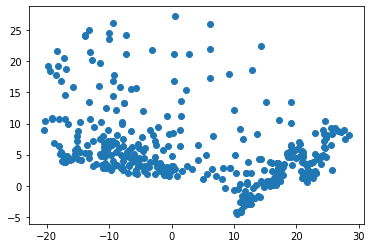

In [5]:
import matplotlib.pyplot as plt
plt.scatter(df.rlon, df.rlat)
plt.show()

In [6]:
# df = df[df.ratio < 3]

df_north = df[df.rlat > dsold_max].copy()
# df_no_zero = df[df[station_dv] != 0.0]
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

# Krig the station only values in the north

In [7]:
station_final_north = krigit_north(df, station_dv, 20, ds)

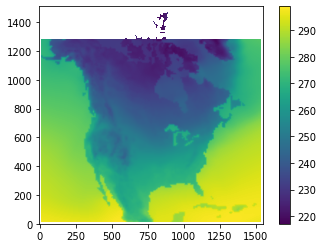

In [8]:
fig, ax = plt.subplots()
col = ax.imshow(ds[dv].values, origin='lower')
plt.colorbar(col)

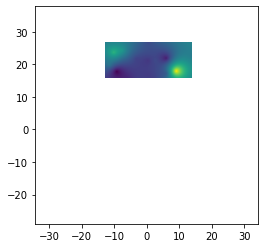

In [9]:
extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
plt.imshow(station_final_north, extent=extent, origin = 'lower')
plt.scatter(df_north.rlon, df_north.rlat)

<AxesSubplot:>

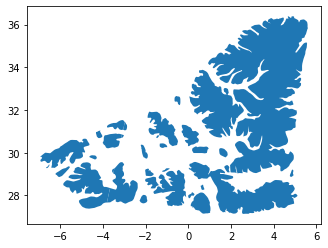

In [10]:
canada = gpd.read_file('./data/processed/canada_final.shp').geometry
def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

canada_polygons = MultiPolygon(to_polygons(canada))

polygon_above_north_idx = np.array(
    [p.centroid.y + 1 >= dsold_max for p in canada]
)

M2 = gpd.GeoSeries(
    MultiPolygon(
        [P for P in canada_polygons if (P.is_valid and P.centroid.y + 1 >= dsold_max)]
    )
)
M2.plot()

100%|██████████| 59147/59147 [00:08<00:00, 6606.17it/s]


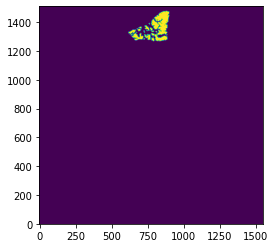

In [11]:
northern_mask = np.zeros(ds[dv].shape) == 1.0
north_ext = 210
northern_mask[-(north_ext+50):, :] = gen_raster_mask_from_vector(
    ds.rlon.values, 
    ds.rlat.values[-(north_ext+50):], 
    M2
)

station_final_north[~northern_mask] = np.nan
plt.imshow(northern_mask, origin='lower')

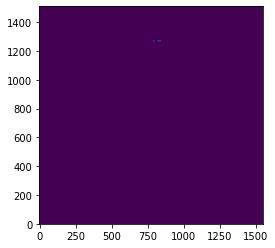

In [12]:
plt.imshow(~np.isnan(station_final_north), origin='lower')

In [13]:
np.nanmin(ds[dv].values)

217.08988780276644

## Find areas in north that are not covered by station only reconstruction

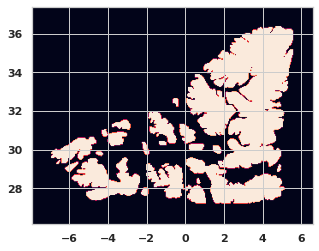

array([231.95, 231.95, 231.95, ..., 231.65, 231.65, 231.65])

In [67]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')

north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]

plt.imshow(missed_station_only, origin='lower', extent=extent)
plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.show()

station_final_north[~northern_mask] = np.nan

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
# f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])
# knr.fit(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])
knr.fit(np.stack([df.rlon, df.rlat]).T, df[station_dv])


station_final_north_filled = station_final_north.copy()
# station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
station_final_north_filled[missed_station_only] = knr.predict(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
station_final_north_filled[~northern_mask] = np.nan

knr.predict(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)

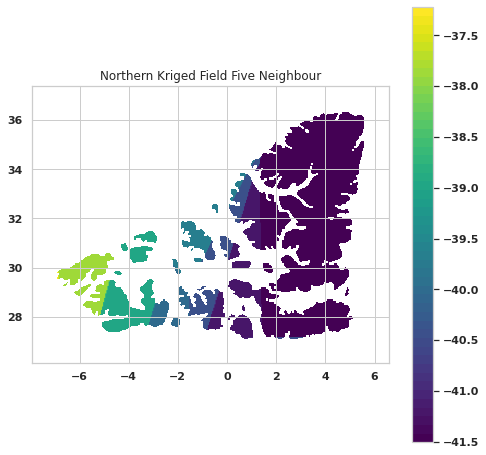

In [70]:
matplotlib.rc('font', **font)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(station_final_north_filled-273.15, origin='lower', extent = extent, cmap = plt.cm.get_cmap("viridis", 50))
plt.scatter(df_north.rlon, df_north.rlat, color='r')
ax.set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
ax.set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.colorbar(img)
plt.title("Northern Kriged Field Five Neighbour")
plt.savefig("northern_krig_5_neighbour")

In [69]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix

In [17]:
# choose starting value
model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
station_vals = df[station_dv]
best_tol = df.best_tol.mean()    

print(best_tol)

# apply correction
model_vals_corrected = (model_vals/best_tol)# + 273.15
mean_corrected = (ds[dv].values/best_tol)# + 273.15

1.0045478527426557


In [18]:
np.nanmean(mean_corrected), np.nanmin(ds[dv].values)

(262.53008055466796, 217.08988780276644)

In [19]:
# latlon = np.stack([df.rlon, df.rlat])
# hull = ConvexHull(points=latlon.T)
# poly = Polygon(latlon.T[hull.vertices])
# poly_mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values[l:r], gpd.GeoSeries(poly), progress_bar=False)
# plt.imshow(poly_mask)

In [20]:
# ok = OrdinaryKriging(
#     df.rlon, 
#     df.rlat, 
#     df.ratio, 
#     exact_values=False,
#     variogram_function='exponential',
# )
# z, ss = ok.execute("grid", ds.rlon.values, ds.rlat.values, backend='C', n_closest_points=30)

In [21]:
df[['rlon', 'rlat', 'ratio']].values[:, :2]

import rpy2

In [22]:
from climpyrical.rkrig import rkrig_r

ratio = rkrig_r(df_south, 30, ds, station_dv)
ratio[~mask] = np.nan

100%|██████████| 373/373 [02:47<00:00,  1.17it/s]/home/nannau/09092020/climpyrical/climpyrical/rkrig.py:237: RuntimeWarning: invalid value encountered in true_divide
  return field / nancount



In [23]:
cxmin, cxmax, cymin, cymax = canada.bounds.minx.min(), canada.bounds.maxx.max(), canada.bounds.miny.min(), canada.bounds.maxy.max()

/home/nannau/tri/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

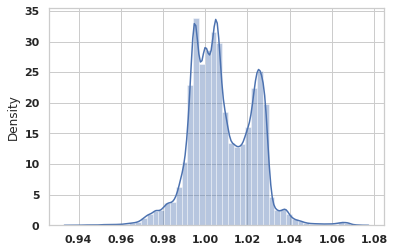

In [71]:
import seaborn as sns
sns.distplot(ratio[~np.isnan(ratio)])

In [72]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

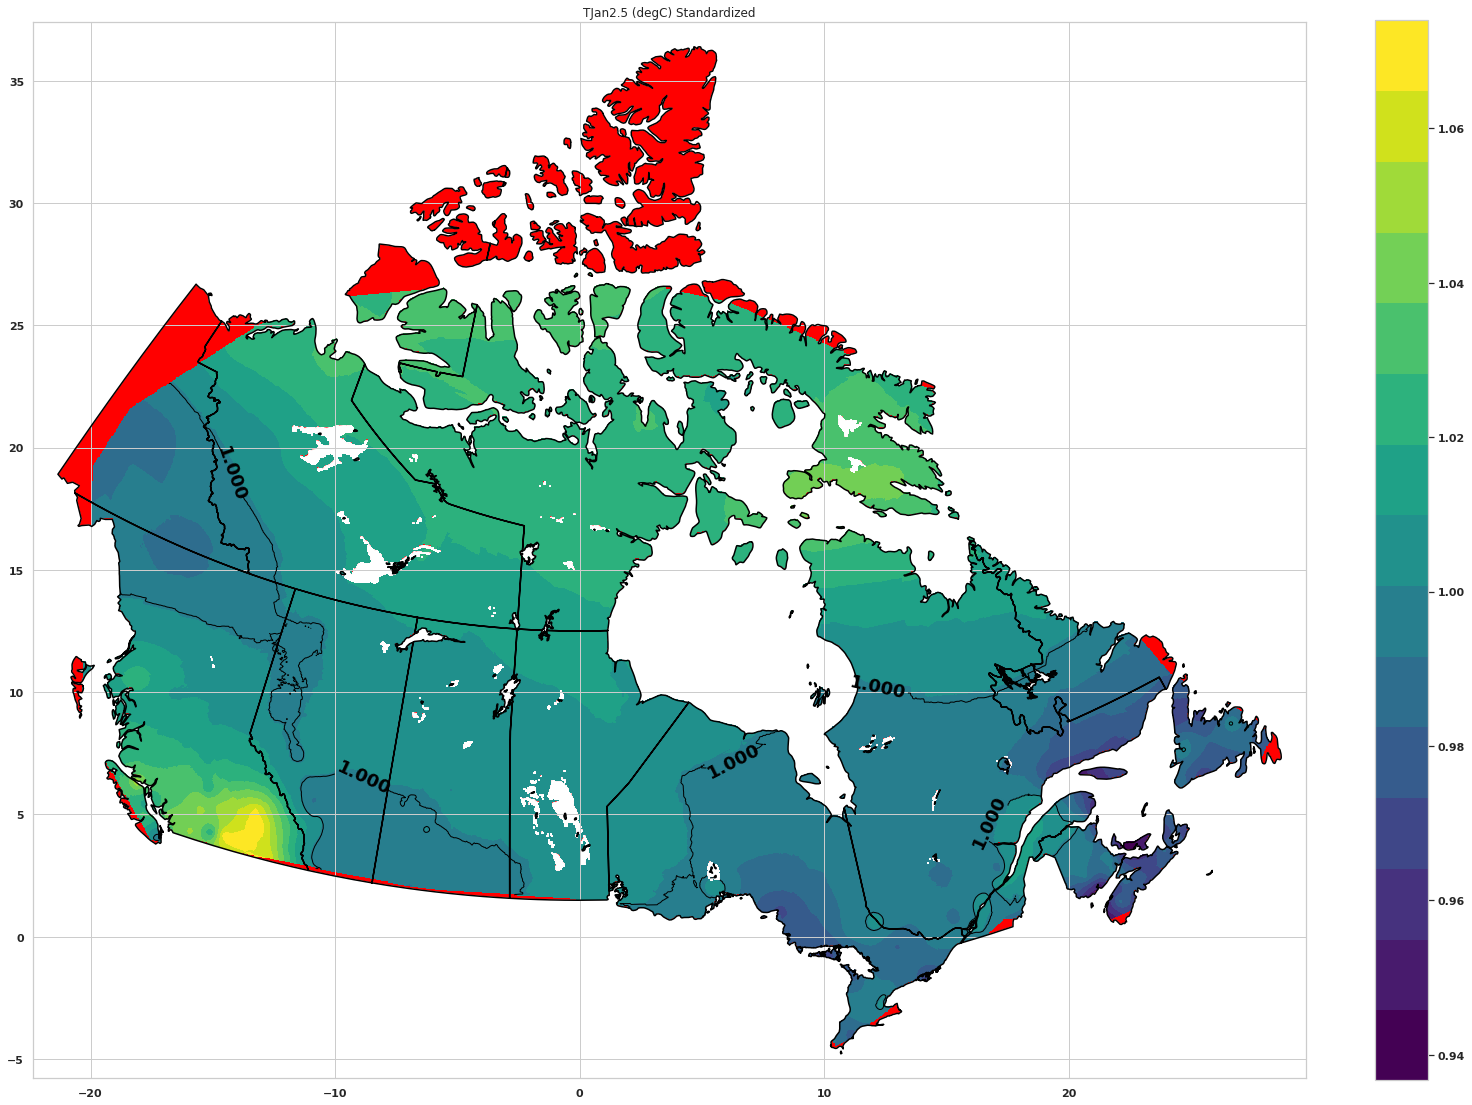

In [73]:
ratio = np.array(ratio, dtype=np.float)


fig, ax = plt.subplots(figsize=(25, 25))

# vmax = np.nanmax(df[station_dv].values)
# vmin = np.nanmin(df[station_dv].values)
# vmin = 5
vmin = 0
vmax = 3


N = 15
cont = np.arange(vmin, vmax, 1)

col1 = ax.imshow(ratio, origin='lower', extent=extent, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)
ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Standardized')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/standardized-{station_dv}-Z-full-reconstruction-patched.png')

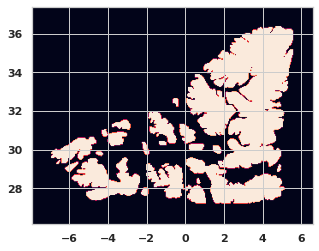

In [80]:
nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()

f = NearestNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, ratio[nanmask])

ratio_final[nanmask^mask] = f(np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T)

ratio_final = ratio_final*mean_corrected


knr = KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='euclidean')

north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

plt.imshow(missed_station_only, origin='lower', extent=extent)
plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.show()

station_final_north[~northern_mask] = np.nan

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
# f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])
# knr.fit(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])
knr.fit(np.stack([rlon[mask].flatten(), rlat[mask].flatten()]).T, ratio_final[mask])


station_final_north_filled = station_final_north.copy()
# station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
station_final_north_filled[missed_station_only] = knr.predict(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)
station_final_north_filled[~northern_mask] = np.nan

# knr.predict(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)


ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
ratio_final -= 273.15


In [81]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

/home/nannau/tri/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/nannau/tri/lib/python3.7/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/nannau/tri/lib/python3.7/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/nannau/tri/lib/python3.7/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/nannau/tri/lib/python3.7/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)
/home/nannau/tri/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


array([nan, nan, nan, ..., nan, nan, nan])

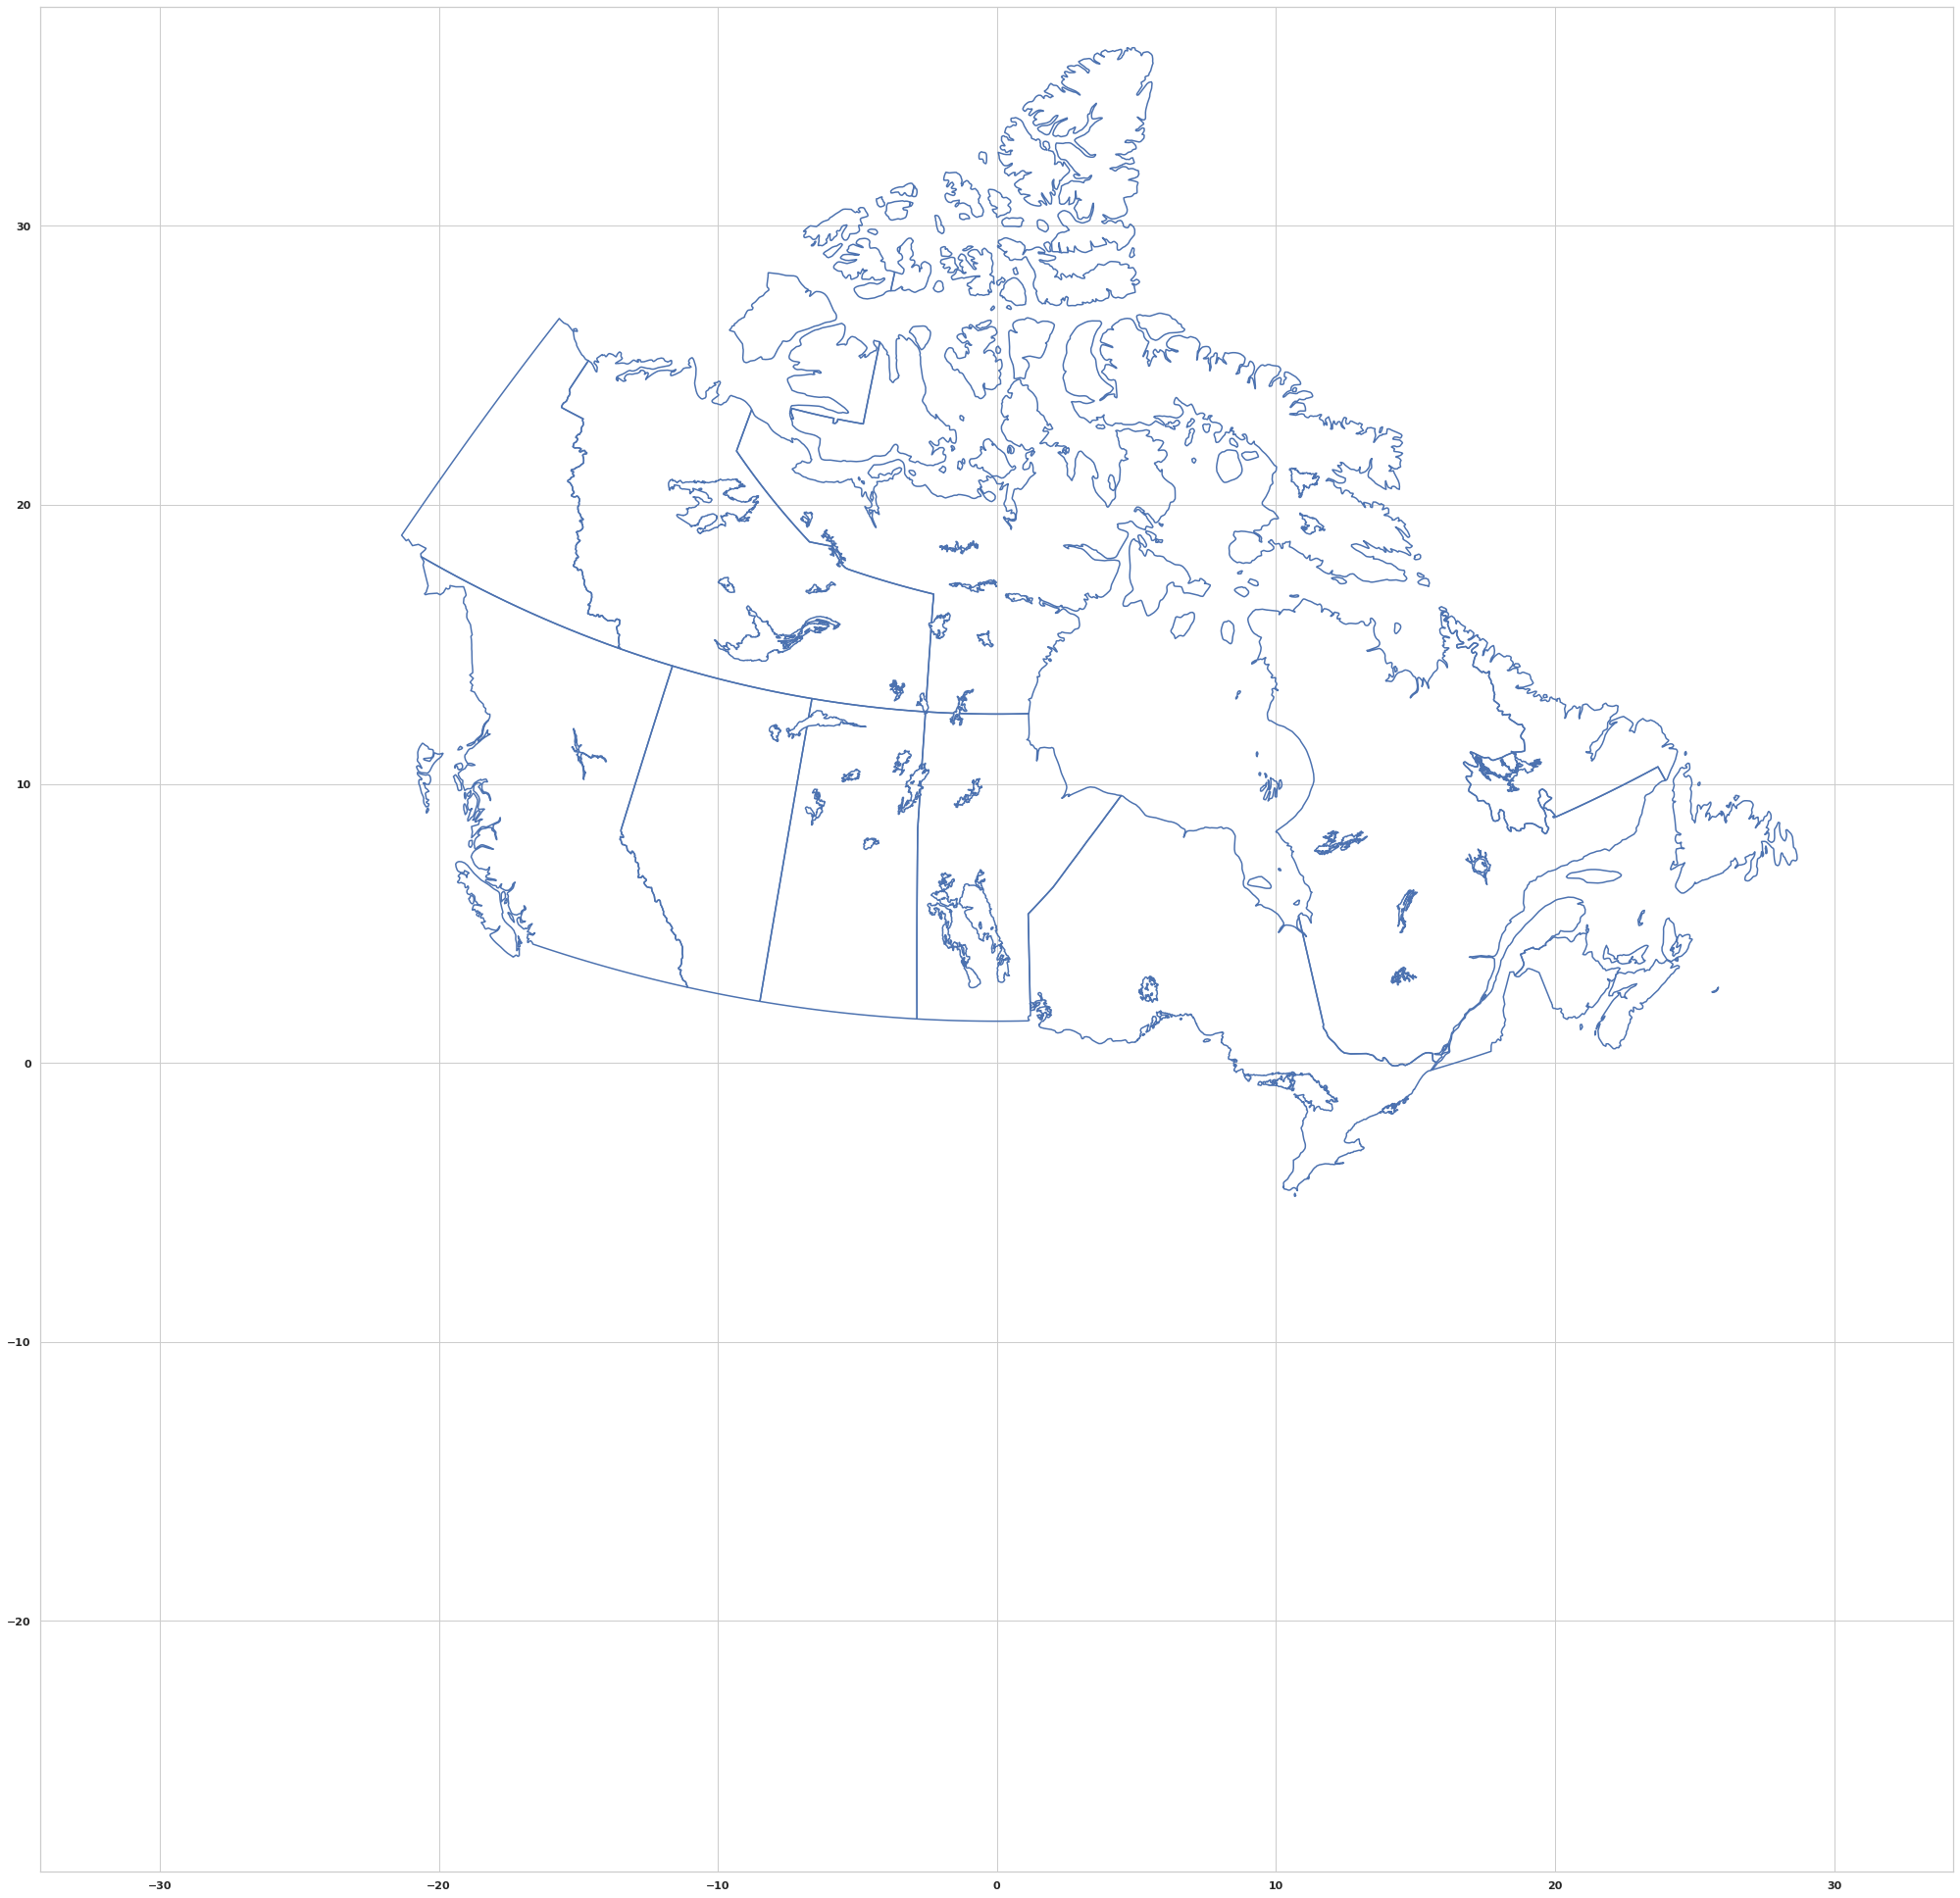

In [82]:
rcopy = ratio_final.copy()
rcopy[~(ratio_final < -50)] = np.nan

fig, ax = plt.subplots(figsize=(35, 35))
ax.imshow(rcopy, origin='lower', extent=extent)
canada.boundary.plot(ax=ax)
# ax.set_xlim(25, 35)
# ax.set_ylim(-20, 0)

ratio_final[~(ratio_final < -50)]

[-50 -48 -46 -44 -42 -40 -38 -36 -34 -32 -30 -28 -26 -24 -22 -20 -18 -16
 -14 -12 -10  -8  -6  -4  -2   0   2   4]


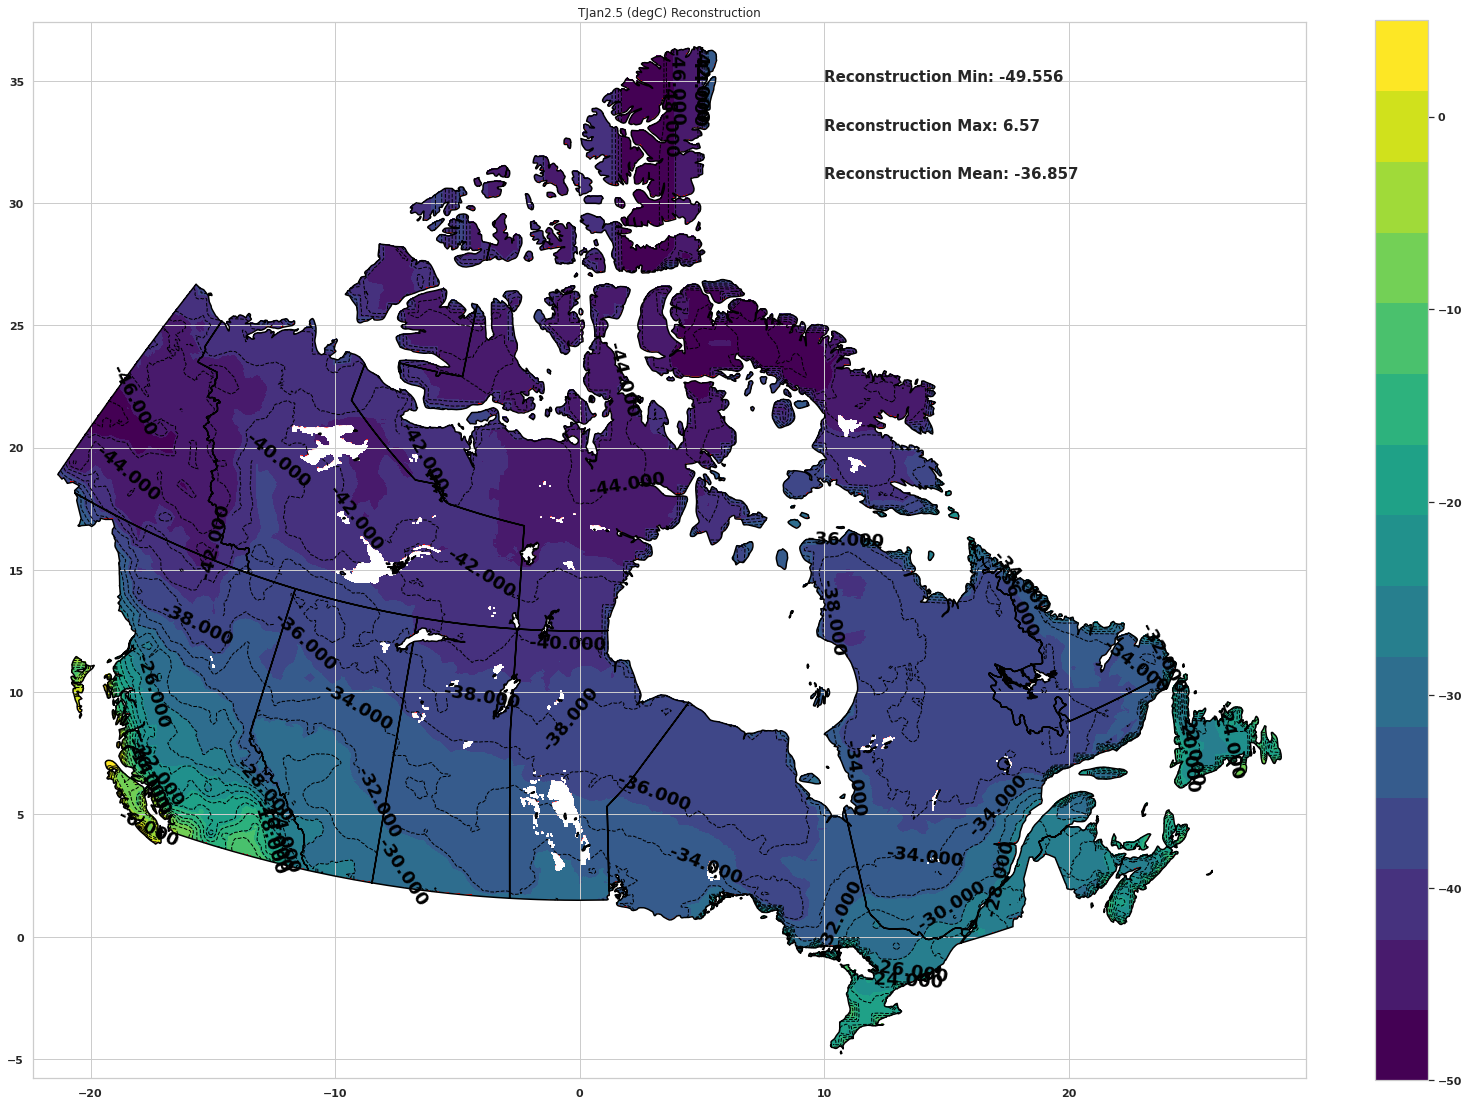

In [83]:
ratio_final[~mask] = np.nan

df = df.assign(station_dv = df[station_dv] - 273.15)

fig, ax = plt.subplots(figsize=(25, 25))

vmin = 5
vmax = -50


N = 15
cont = np.arange(vmax, vmin, 2)
print(cont)

ax.text(10, 35, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)))
ax.text(10, 33, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)))
ax.text(10, 31, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)))

col1 = ax.imshow(ratio_final, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio_final, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Reconstruction')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}-reconstruction.png')

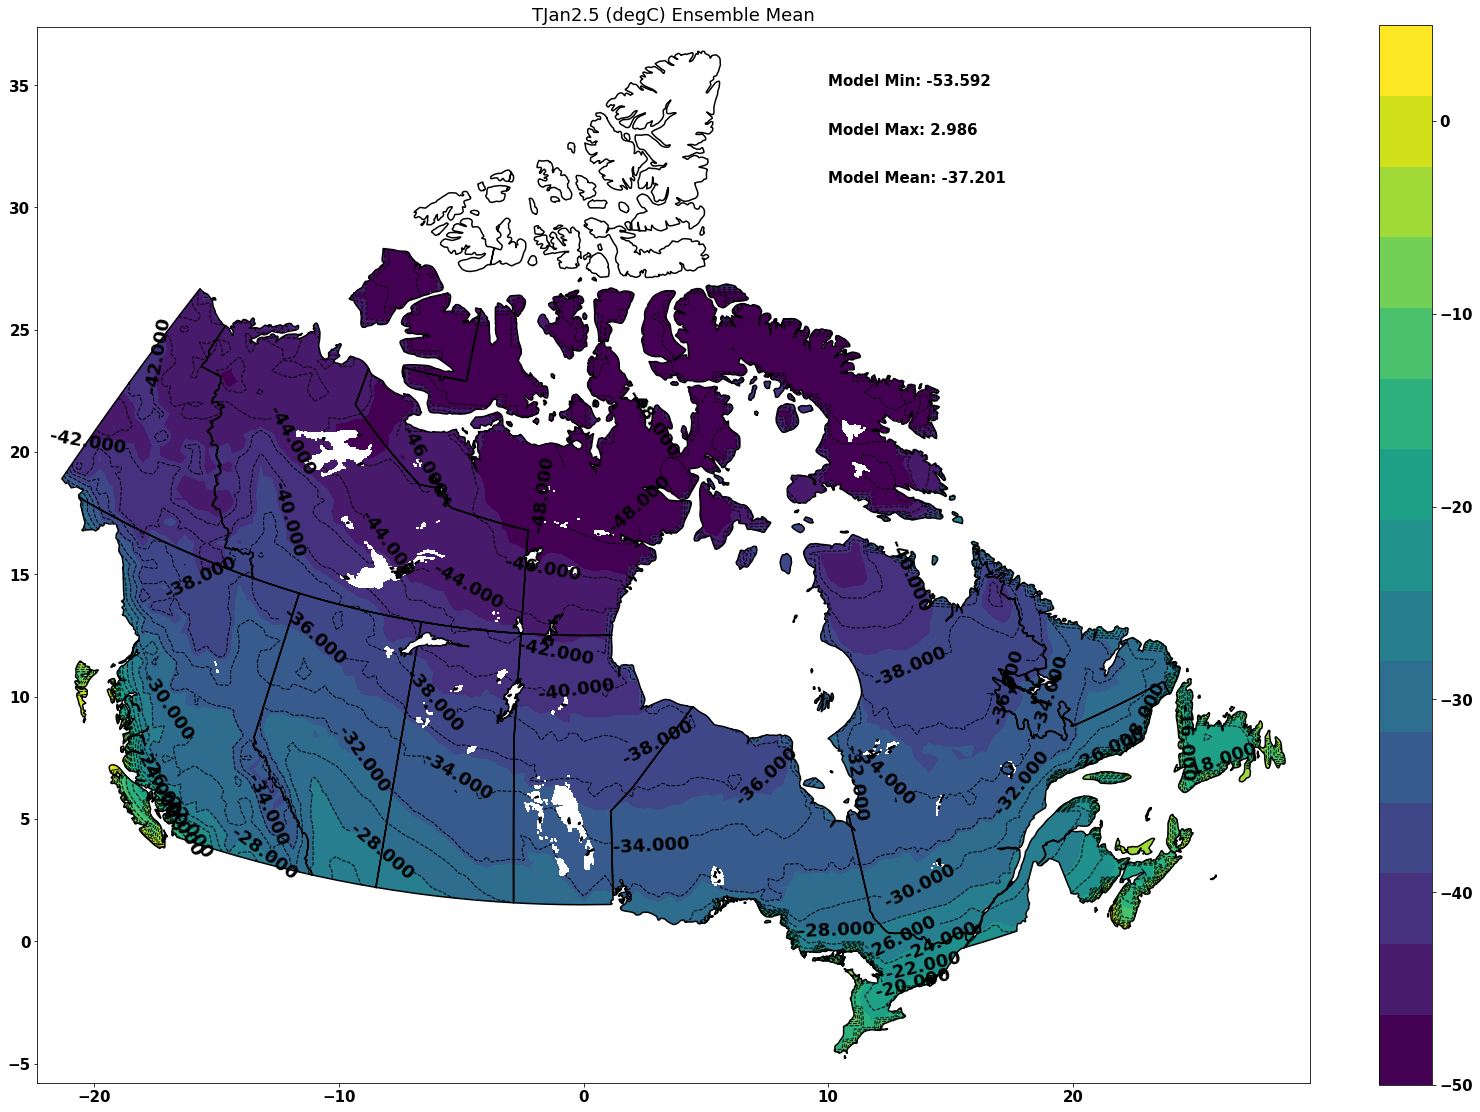

In [36]:
mean = ds[dv].values
mean[~mask] = np.nan
mean[northern_mask] = np.nan
mean -= 273.15
fig, ax = plt.subplots(figsize=(25, 25))



col1 = ax.imshow(mean, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, mean, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.text(10, 35, 'Model Min: {}'.format(np.round(np.nanmin(mean[mask]), 3)))
ax.text(10, 33, 'Model Max: {}'.format(np.round(np.nanmax(mean[mask]), 3)))
ax.text(10, 31, 'Model Mean: {}'.format(np.round(np.nanmean(mean[mask]), 3)))

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Ensemble Mean')
# canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_CanRCM4_ensmean.png')

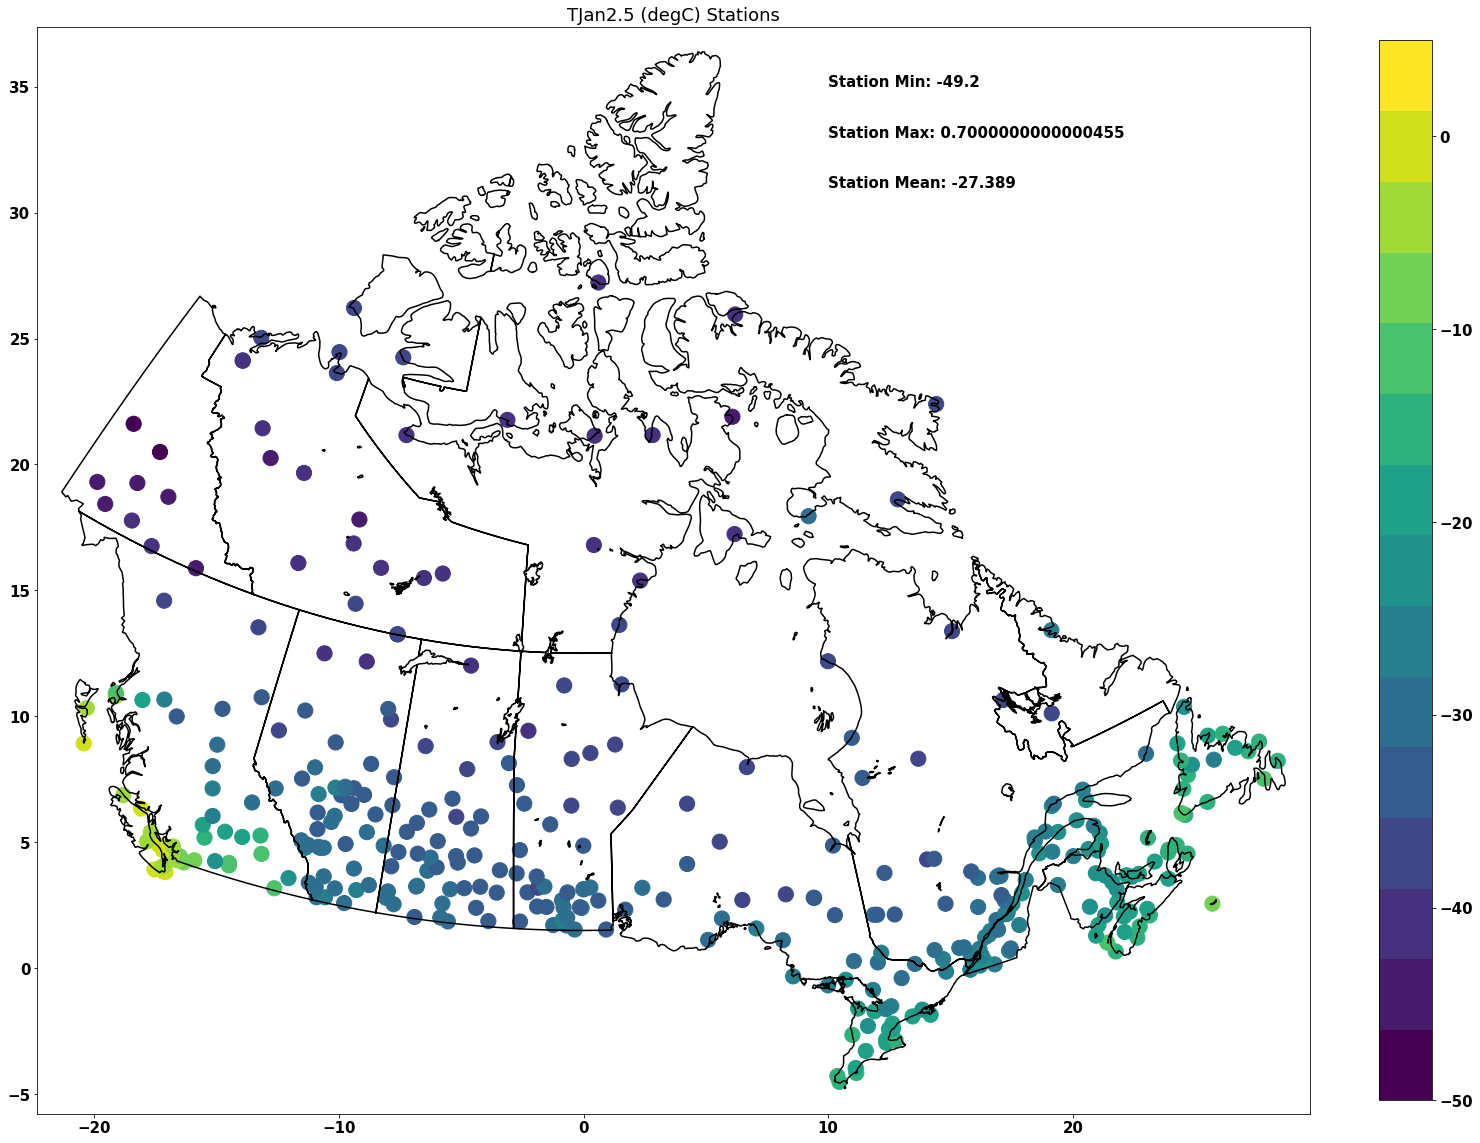

In [38]:
# ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
# ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 20))
station_vals_deg_c = df[station_dv] - 273.15
sc = ax.scatter(df.rlon, df.rlat, c = station_vals_deg_c, s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap("viridis", N))
plt.colorbar(sc, ax = ax, fraction=0.038, pad=0.05)

ax.text(10, 35, 'Station Min: {}'.format(np.round(np.min(station_vals_deg_c), 3)))
ax.text(10, 33, 'Station Max: {}'.format(np.max(station_vals_deg_c)))
ax.text(10, 31, 'Station Mean: {}'.format(np.round(np.nanmean(station_vals_deg_c), 3)))

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.set_title(station_dv+' Stations')
ax.plot(X, Y, color='black')

plt.savefig(f'./data/reporting/{file_dv}_stations.png')

# Write to Table C-2


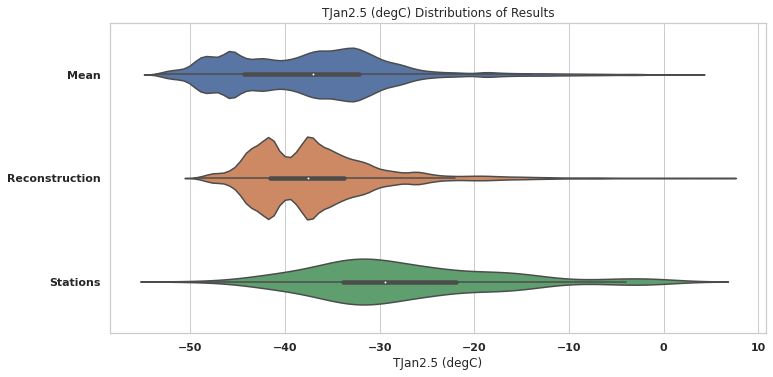

In [41]:
# sns.violinplot
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 5))

violindata = np.concatenate([ds[dv].values.flatten(), ratio_final.flatten(), station_vals_deg_c])

means_str = ["Mean" for x in ds[dv].values.flatten()]
ratio_str = ["Reconstruction" for x in ratio_final.flatten()]
station_str = ["Stations" for x in station_vals_deg_c]

vstrings = np.concatenate([means_str, ratio_str, station_str])

vdf = pd.DataFrame({station_dv: violindata, '': vstrings})
plt.tight_layout()

ax.set_title(f"{station_dv} Distributions of Results")
sns.violinplot(ax=ax, x=station_dv, y='', data=vdf)
plt.savefig(f'./data/reporting/{file_dv}-violin.png', bbox_inches='tight')

In [44]:
matched_df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

nrc_nan_df = matched_df_nrc[np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])]

ratio_nan = ~np.isnan(ratio_final)
    
f = NearestNDInterpolator(np.stack([rlon[ratio_nan], rlat[ratio_nan]]).T, ratio_final[ratio_nan])

table_nan = f(
    np.stack(
        [rlon[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values], 
         rlat[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values]
        ]).T).T

# matched_df_nrc[''][np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])] = table_nan
# matched_df_nrc

design_value = ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx]
dvnan = np.isnan(design_value)
design_value[dvnan] = table_nan

nrc_table = pd.DataFrame()
nrc_table[station_dv] = design_value
nrc_table = nrc_table.assign(
    Location=matched_df_nrc.Location, 
    lat=matched_df_nrc.lat, 
    lon=matched_df_nrc.lon,
    rlat=matched_df_nrc.rlat, 
    rlon=matched_df_nrc.rlon)

assert not df.isnull().values.any()

nrc_table.round(3).to_csv("./data/reporting/"+file_dv+"TableC2.csv")

In [50]:
!pwd
!source upload_files.sh

/home/nannau/09092020/climpyrical/notebooks/dev

Welcome to PCIC compute! Please use your Netlink ID to login.


Welcome to PCIC compute! Please use your Netlink ID to login.



In [67]:
from climpyrical.mask import flatten_coords
a = np.array(['Kirsten', 'Chelsea', 'Dill', 'Jae','Alice', 'Ella', 'Maya', 'Becca', 'Hannah', 'Karine'])
b = a.copy()
a, b = flatten_coords(a, b)
df = pd.DataFrame({'a': a, 'b': b})
df = df[a != b]
# df = df.drop_duplicates()
# df[pd.DataFrame(np.sort(df[['a','b']].values,1)).duplicated()]
res = df[~df[['a', 'b']].apply(frozenset, axis=1).duplicated()]
res.to_csv('/home/nannau/Desktop/bonk.csv')

In [68]:
res

,a,b
1,Chelsea,Kirsten
2,Dill,Kirsten
3,Jae,Kirsten
4,Alice,Kirsten
5,Ella,Kirsten
6,Maya,Kirsten
7,Becca,Kirsten
8,Hannah,Kirsten
9,Karine,Kirsten
12,Dill,Chelsea
